In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [float(e) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till)
        m = sum(elems) / len(elems)
        yield m

In [52]:
def make_read_write_graph(ax, basedir, title, scalability=False, n_threads=1):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm')]
    numerical.sort()
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm', skip=1))
    #results3 = list(results_generator(l, basedir + '/mmio', skip=0, till=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR')
    ax.plot(numerical, results2, 'x', label='HBM')
    #ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability:
        if n_threads > 1:
            ax.axvline(x=65536*n_threads, linestyle=(0, (1, 10)), label = f'CPU L1 x {n_threads}')
            ax.axvline(x=1048576*n_threads, linestyle=(0, (3, 10, 1, 10)), label = f'CPU L2 x {n_threads}')
        ax.axvline(x=65536, ls=':', label = f'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = f'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

def make_copy_graph(ax, basedir, title, scalability=False):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_ddr')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr_ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm_hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/hbm_ddr', skip=1))
    results4 = list(results_generator(l, basedir + '/ddr_hbm', skip=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR->DDR')
    ax.plot(numerical, results2, 'x', label='HBM->HBM')
    ax.plot(numerical, results3, 's', label='HBM->DDR')
    ax.plot(numerical, results4, '^', label='DDR->HBM')
    if not scalability:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

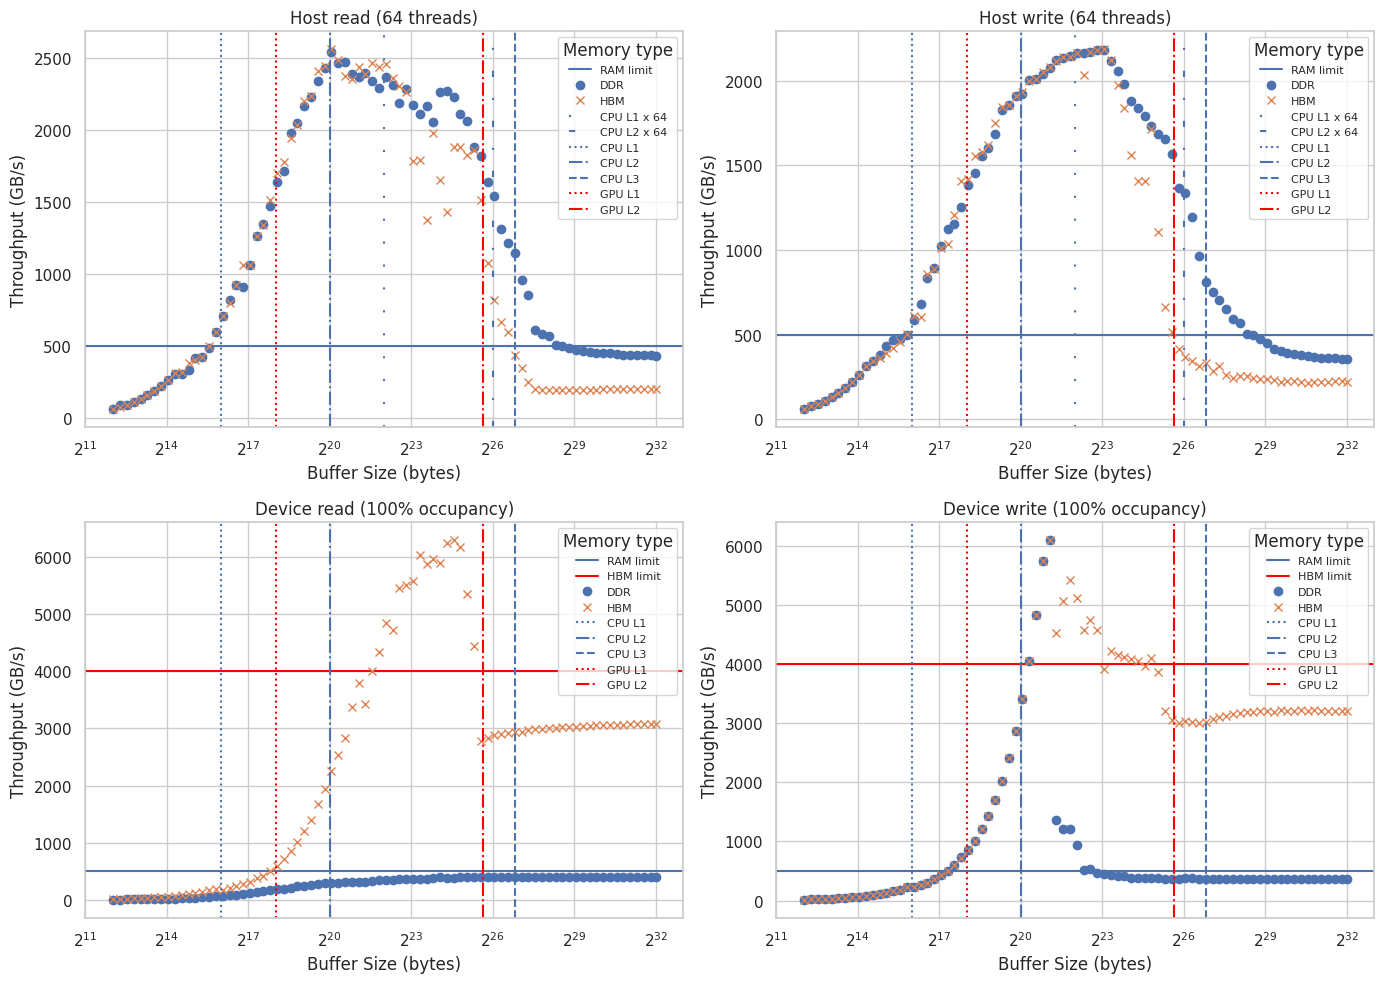

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
ax1.axhline(y=500, label='RAM limit')
make_read_write_graph(ax1, 'results/read/host', 'Host read (64 threads)', False, 64)
ax2.axhline(y=500, label='RAM limit')
make_read_write_graph(ax2, 'results/write/host', 'Host write (64 threads)', False, 64)
ax3.axhline(y=500, label='RAM limit')
ax3.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax3, 'results/read/device', 'Device read (100% occupancy)')
ax4.axhline(y=500, label='RAM limit')
ax4.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax4, 'results/write/device', 'Device write (100% occupancy)')
plt.tight_layout()

host ddr read max 19.169533333333334
host hbm read max 7.580887777777777


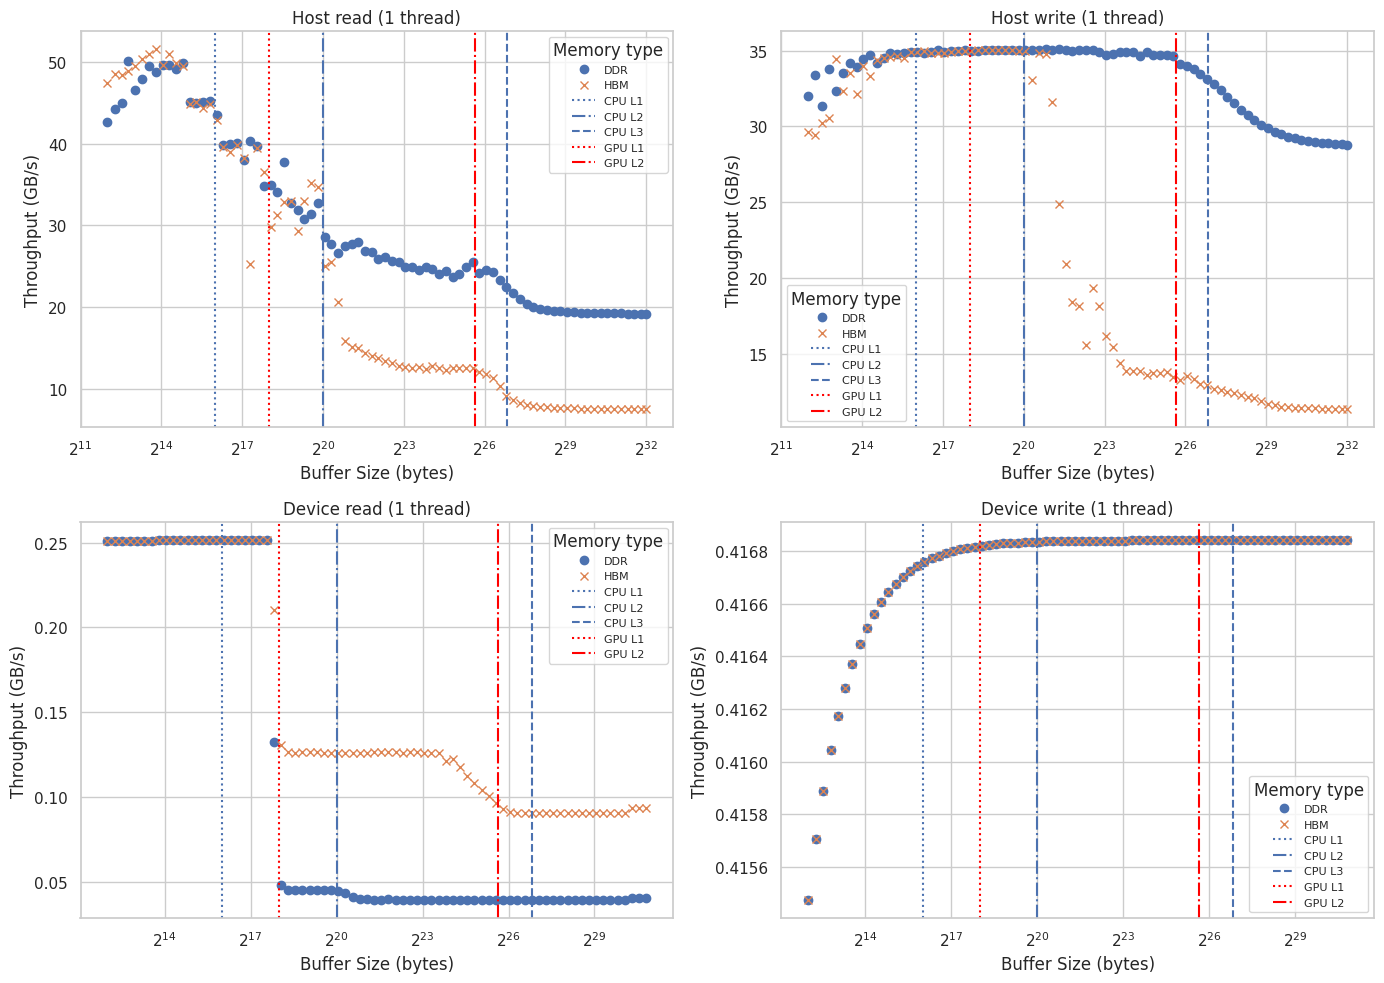

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
make_read_write_graph(ax1, 'results/read/host/single', 'Host read (1 thread)')
make_read_write_graph(ax2, 'results/write/host/single', 'Host write (1 thread)')
make_read_write_graph(ax3, 'results/read/device/single', 'Device read (1 thread)')
make_read_write_graph(ax4, 'results/write/device/single', 'Device write (1 thread)')
plt.tight_layout()

#getting maxes
host_reads = list(results_generator([str(2**32)], 'results/read/host/single/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr read max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/read/host/single/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm read max {host_reads[0]}')

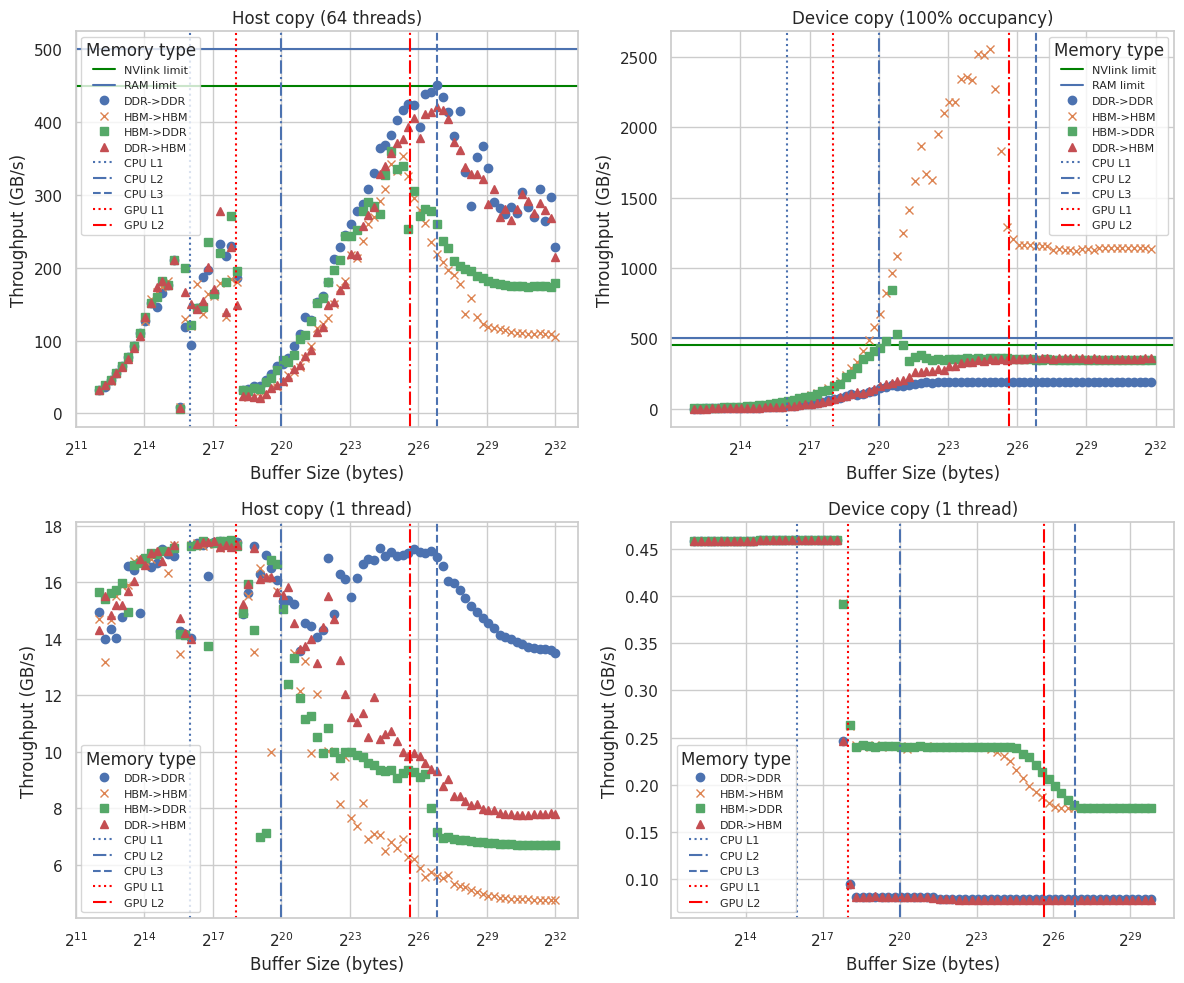

In [54]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
make_copy_graph(ax1, 'results/copy/host', 'Host copy (64 threads)')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
# ax2.axhline(y=4000, color='red', label='HBM limit')
make_copy_graph(ax2, 'results/copy/device', 'Device copy (100% occupancy)')
make_copy_graph(ax3, 'results/copy/host/single', 'Host copy (1 thread)')
make_copy_graph(ax4, 'results/copy/device/single', 'Device copy (1 thread)')
plt.tight_layout()

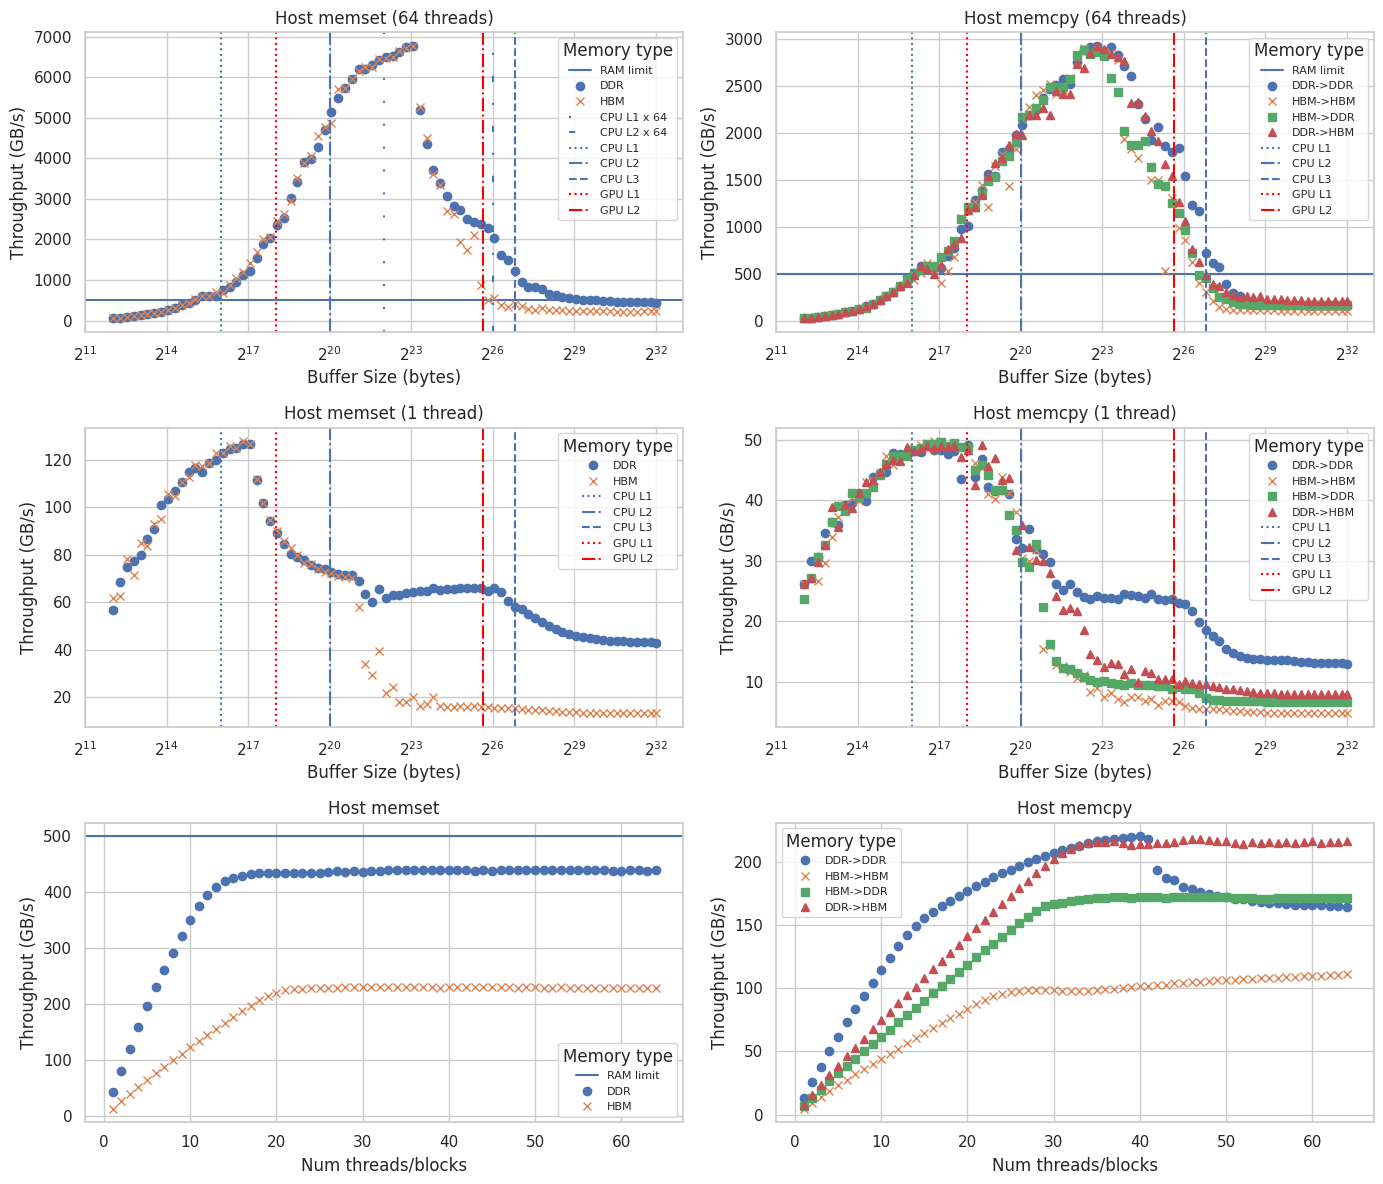

In [56]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))
ax1.axhline(y=500, label='RAM limit')
make_read_write_graph(ax1, 'results/memset/host', 'Host memset (64 threads)', False, 64)
ax2.axhline(y=500, label='RAM limit')
make_copy_graph(ax2, 'results/memcpy/host', 'Host memcpy (64 threads)')
make_read_write_graph(ax3, 'results/memset/host/single', 'Host memset (1 thread)')
make_copy_graph(ax4, 'results/memcpy/host/single', 'Host memcpy (1 thread)')
ax5.axhline(y=500, label='RAM limit')
make_read_write_graph(ax5, 'results/memset/host/scalability', 'Host memset', True)
make_copy_graph(ax6, 'results/memcpy/host/scalability', 'Host memcpy', True)
plt.tight_layout()

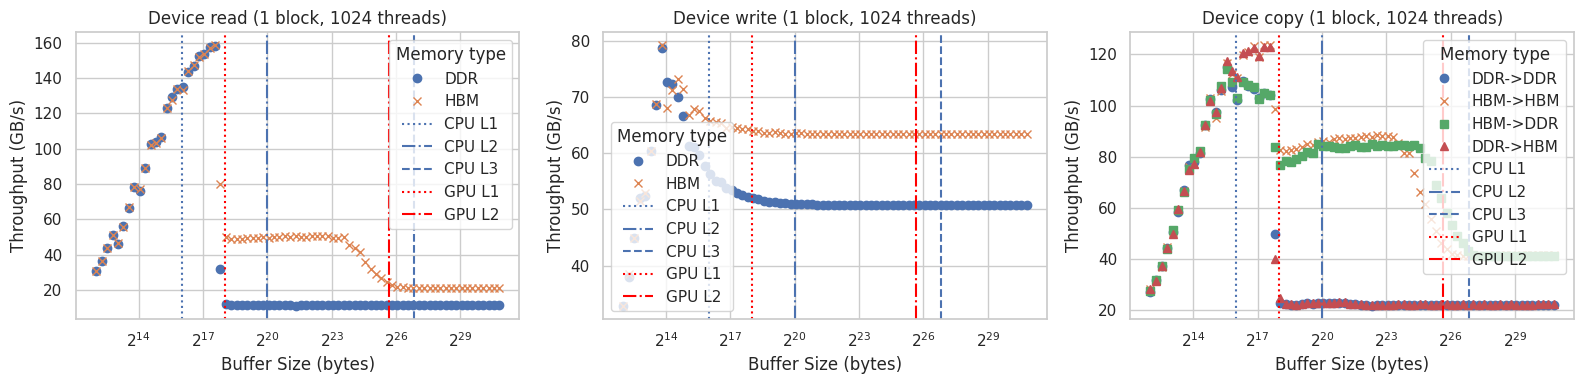

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
make_read_write_graph(ax1, 'results/read/device/block', 'Device read (1 block, 1024 threads)')
make_read_write_graph(ax2, 'results/write/device/block', 'Device write (1 block, 1024 threads)')
make_copy_graph(ax3, 'results/copy/device/block', 'Device copy (1 block, 1024 threads)')
plt.tight_layout()

host (DDR) 226.9471791791792
host (HBM) 587.8251001001
device (HBM) 326.6301371371371
device (DDR) 840.6203643643643
host (DDR) 8.85299988988989
host (HBM) 9.870726706706707
device (HBM) 252.71337737737736
device (DDR) 711.7112092092092


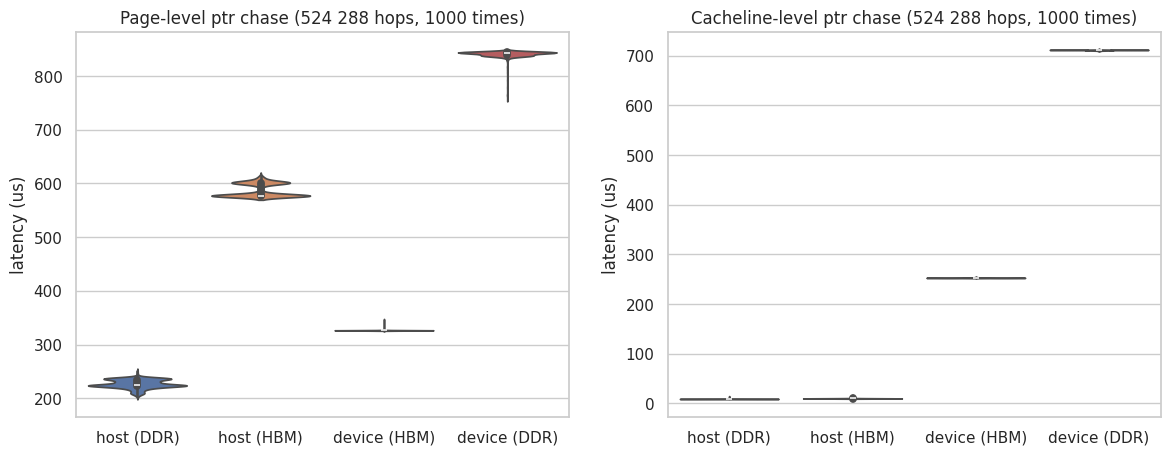

In [40]:
experiments1 = ['host/ddr', 'host/hbm', 'device/hbm', 'device/ddr']
experiments2 = ['fine/host/ddr', 'fine/host/hbm', 'fine/device/hbm', 'fine/device/ddr']
labels = ['host (DDR)', 'host (HBM)', 'device (HBM)', 'device (DDR)']
data1 = {}
data2 = {}

for e, l in zip(experiments1, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data1[l] = elems

for e, l in zip(experiments2, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data2[l] = elems

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_title('Page-level ptr chase (524 288 hops, 1000 times)')
ax2.set_title('Cacheline-level ptr chase (524 288 hops, 1000 times)')
ax1.set_ylabel('latency (us)')
ax2.set_ylabel('latency (us)')
sns.violinplot(data1, ax=ax1)
sns.violinplot(data2, ax=ax2)

# ax3 = fig.add_axes([.58, .5, .2, .3])
# experiments = ['fine/host/ddr', 'fine/host/hbm']
# labels = ['host (DDR)', 'host (HBM)']
# data = {}

# for e, l in zip(experiments, labels):
#     with open('results/latency/' + e, 'r') as file:
#         elems = file.read().split('\n')[1:-1]
#         elems = [float(e) for e in elems]
#         data[l] = elems
# ax = sns.violinplot(data, ax=ax3)

for k, v in data1.items():
    print(k, np.mean(v))
for k, v in data2.items():
    print(k, np.mean(v))

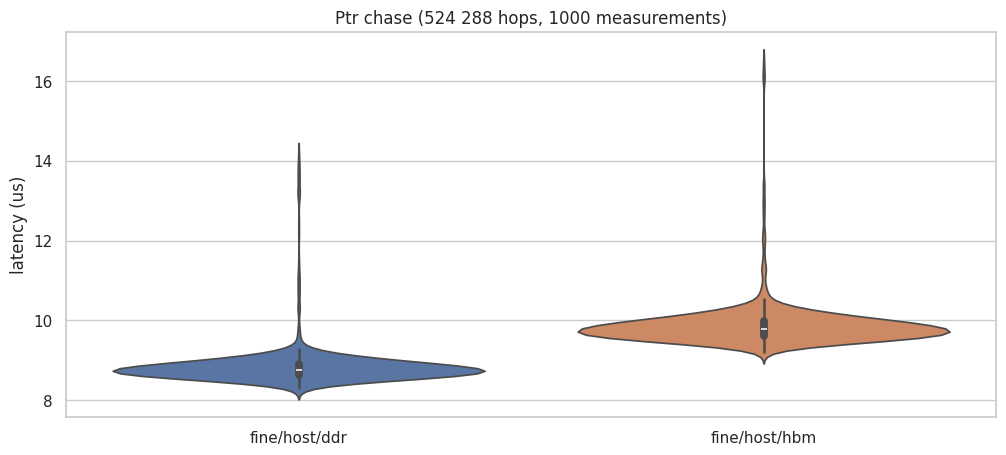

In [32]:
experiments = ['fine/host/ddr', 'fine/host/hbm']
data = {}

for e in experiments:
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data[e] = elems

plt.figure(figsize=(12, 5))
plt.title('Ptr chase (524 288 hops, 1000 measurements)')
plt.ylabel('latency (us)')
ax = sns.violinplot(data)

host ddr read max 430.24577777777785 (41 threads)
host hbm read max 199.38144444444444 (64 threads)
host ddr write max 362.48844444444444 (62 threads)
host hbm write max 230.61344444444447 (40 threads)
host ddr->ddr copy max 227.48422222222223 (60 threads)
host hbm->hbm copy max 104.85066666666665 (63 threads)
host hbm->ddr copy max 180.00022222222222 (64 threads)
host ddr->hbm copy max 216.9811111111111 (47 threads)


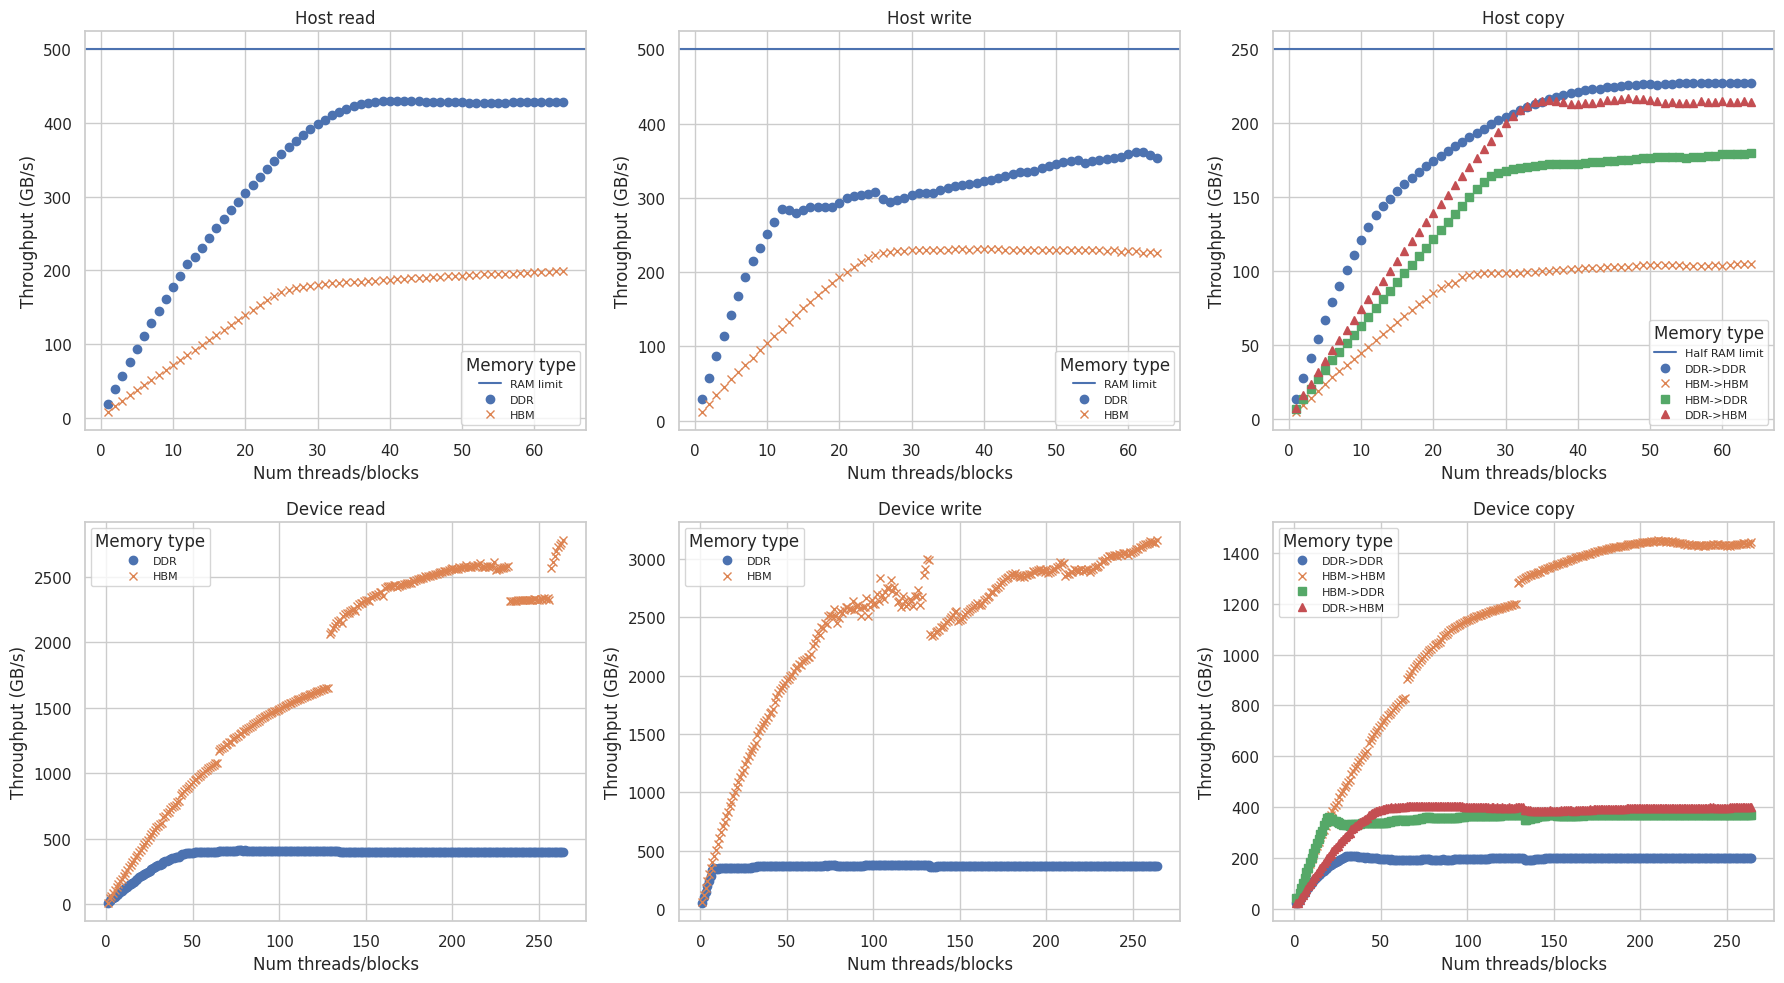

In [65]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18,10))
ax1.axhline(y=500, label='RAM limit')
ax2.axhline(y=500, label='RAM limit')
ax3.axhline(y=250, label='Half RAM limit')
make_read_write_graph(ax1, 'results/read/host/scalability', 'Host read', True)
make_read_write_graph(ax2, 'results/write/host/scalability', 'Host write', True)
make_copy_graph(ax3, 'results/copy/host/scalability', 'Host copy', True)
make_read_write_graph(ax4, 'results/read/device/scalability', 'Device read', True)
make_read_write_graph(ax5, 'results/write/device/scalability', 'Device write', True)
make_copy_graph(ax6, 'results/copy/device/scalability', 'Device copy', True)
plt.tight_layout()

#getting maxes
l = list(str(elem) for elem in range(1,65))
host_reads = list(results_generator(l, 'results/read/host/scalability/ddr', skip=1))
am = np.argmax(host_reads)
print(f'host ddr read max {host_reads[am]} ({am+1} threads)')
host_reads = list(results_generator(l, 'results/read/host/scalability/hbm', skip=1))
am = np.argmax(host_reads)
print(f'host hbm read max {host_reads[am]} ({am+1} threads)')
host_writes = list(results_generator(l, 'results/write/host/scalability/ddr', skip=1))
am = np.argmax(host_writes)
print(f'host ddr write max {host_writes[am]} ({am+1} threads)')
host_writes = list(results_generator(l, 'results/write/host/scalability/hbm', skip=1))
am = np.argmax(host_writes)
print(f'host hbm write max {host_writes[am]} ({am+1} threads)')


host_copies = list(results_generator(l, 'results/copy/host/scalability/ddr_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/copy/host/scalability/hbm_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->hbm copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/copy/host/scalability/hbm_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/copy/host/scalability/ddr_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->hbm copy max {host_copies[am]} ({am+1} threads)')

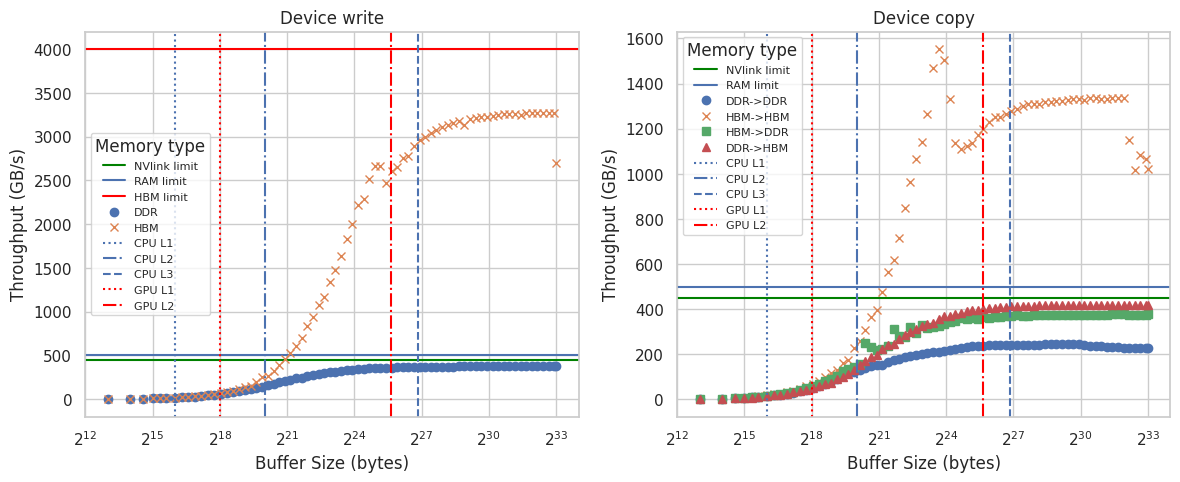

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
ax1.axhline(y=4000, color='red', label='HBM limit')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
#ax2.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax1, 'results/write/device/throughput', 'Device write')
make_copy_graph(ax2, 'results/copy/device/throughput', 'Device copy')